In [16]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
data_path = "/home/maksim/Documents/data_art.csv"
data = pd.read_csv(data_path)
data = data[pd.notna(data.Image)]
data.reset_index(drop=True, inplace=True)

In [18]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import WebDriverException
import re

def download_images(data, path_to_save, driver_path):
    driver = webdriver.Firefox(executable_path=driver_path)
    driver.maximize_window()
    paths = []
    for url in data.Image:
        try:
            driver.get(url)
            WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.TAG_NAME, "img")))
            row = data[data.Image == url]
            suffix = str(row.Author.values[0]) + "," + str(row.Art.values[0]) + "," + str(row.year.values[0])
            if len(suffix) > 100:
                suffix = suffix[:100]
            filename = path_to_save + re.escape(suffix.replace("/",";"))
            with open(filename, 'wb') as file:
                file.write(driver.find_element_by_tag_name('img').screenshot_as_png)
            paths.append(filename)
        except WebDriverException:
            paths.append("None")
            continue
    driver.close()
    return paths

In [19]:
paths = download_images(data[0:10], path_to_save="/home/maksim/Downloads/", driver_path="/home/maksim/geckodriver")

In [20]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import cv2

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte



def segment_image(path):
    image_rgb = cv2.imread(path)[:,:,::-1]
    image = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    denoised = rank.median(image, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 10
    markers = ndi.label(markers)[0]
    gradient = rank.gradient(denoised, disk(2))
    labels = watershed(gradient, markers)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(image_rgb)
    ax[0].set_title("Original")
    ax[1].imshow(image, cmap=plt.cm.gray)
    ax[1].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
    ax[1].set_title("Segmented")
    for a in ax:
        a.axis('off')
    fig.tight_layout()
    plt.show()
    return labels

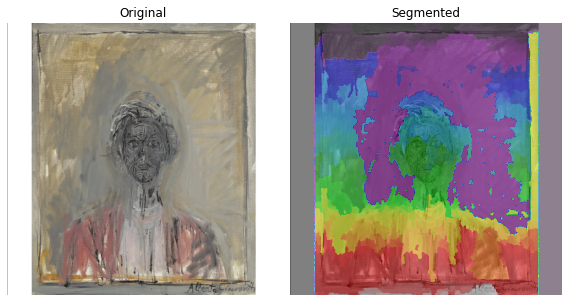

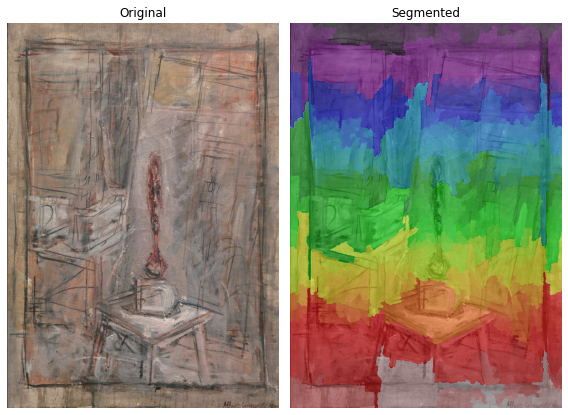

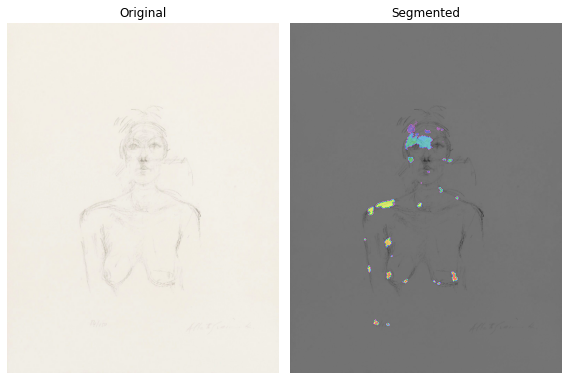

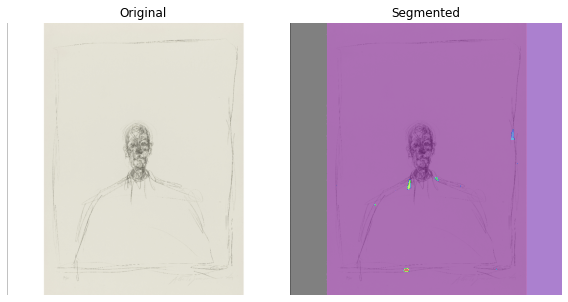

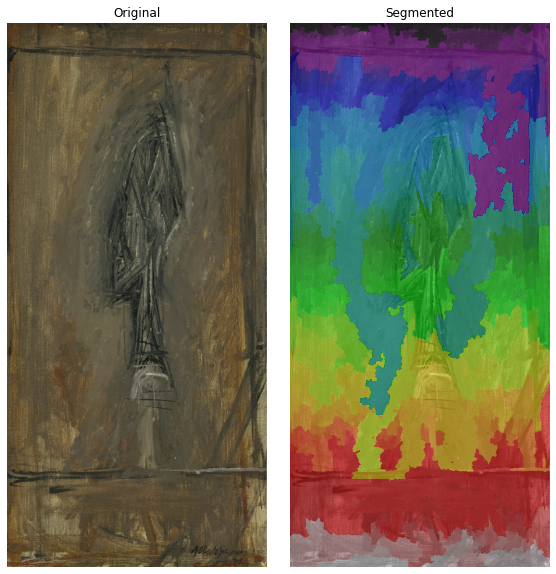

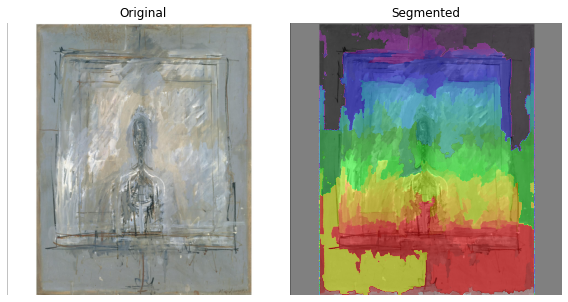

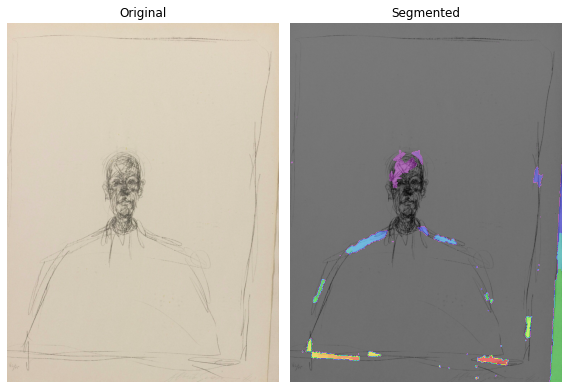

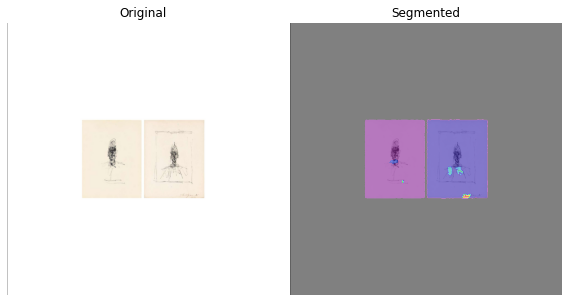

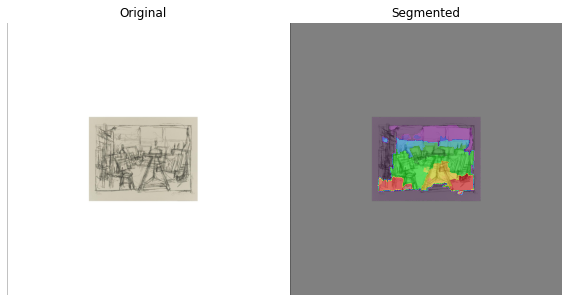

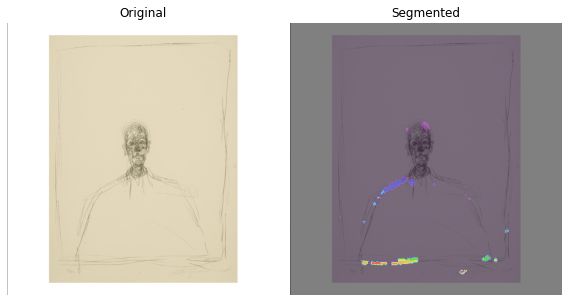

In [21]:
for path in paths:
    segment_image(path)